In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

In [17]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

def results_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Evaluate metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))  # Precision, Recall, F1-score

    # Compute and print ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

## Random forest model using data from last consultations and the child table

In [15]:
last_consult_table = pd.read_parquet('Data/sampled_merged_last_consultation_for_training.parquet')

In [3]:
# need to remove all the information about vaccines from the training data

vaccine_info_columns = ['all_vaccines', 'number_missed_vaccines', 'missed_vaccines_category']

X_df = last_consult_table.drop(columns=vaccine_info_columns)

y_df = last_consult_table['all_vaccines']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=2)

Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.76      0.79     46829
        True       0.88      0.91      0.90     92372

    accuracy                           0.86    139201
   macro avg       0.85      0.84      0.84    139201
weighted avg       0.86      0.86      0.86    139201

ROC-AUC: 0.91
[[35665 11164]
 [ 7958 84414]]


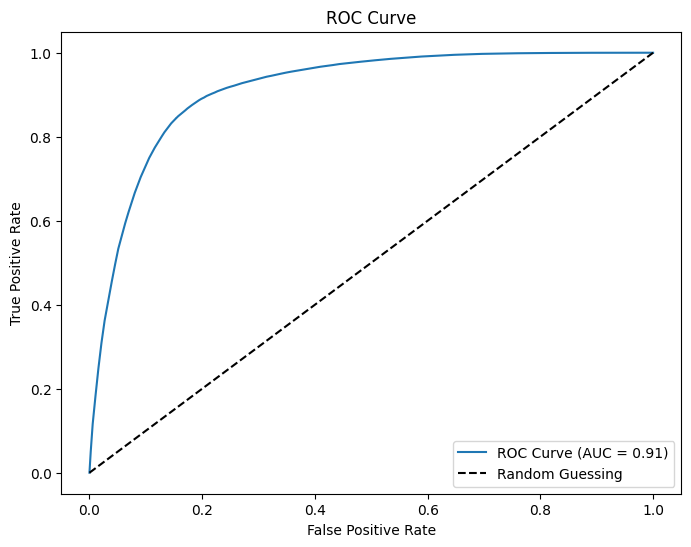

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier_merged_last_consult = RandomForestClassifier(random_state=0)
RF_classifier_merged_last_consult.fit(X_train, y_train)

results_metrics(RF_classifier_merged_last_consult, X_test=X_test, y_test=y_test)

We use GridSearchCV to choose the best parameters for RandomForestClassifier. As it is critical that we detect as many children as possible that might drop out, we prioritize recall for `'all_vaccines'==False` category.

In [18]:
last_consult_table['all_vaccines'].value_counts(normalize=True)*100

all_vaccines
True     66.381252
False    33.618748
Name: proportion, dtype: float64

In [21]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV


# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2],
    'class_weight': [None, 'balanced', {0: 2, 1: 1}, {0: 3, 1: 1}],
    'max_features': ['log2','sqrt']
}

# Custom scorer for recall of the False class
custom_scorer = make_scorer(recall_score, pos_label=False)



grid_search_merged_last_consult = GridSearchCV(
    RandomForestClassifier(random_state=2),
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search_merged_last_consult.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_merged_last_consult.best_params_)
print("Best Recall Score:", grid_search_merged_last_consult.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.5s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.5s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.6s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.6s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  24.7s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  24.8s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n

/Users/dujell0000/Documents/H4G/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.9min
[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.9min
[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  44.2s
[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  44.2s
[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  44.5s
[CV] END class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  33.5s
[CV] END class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  33.5s
[CV] END class_weight=No

Best Parameters: {'class_weight': {0: 3, 1: 1}, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

       False       0.65      0.87      0.74     46829
        True       0.92      0.77      0.84     92372

    accuracy                           0.80    139201
   macro avg       0.79      0.82      0.79    139201
weighted avg       0.83      0.80      0.81    139201

ROC-AUC: 0.89


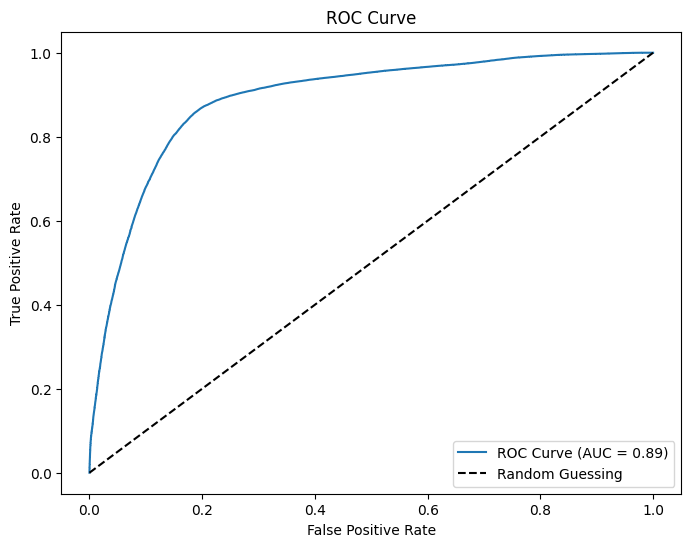

In [24]:
RF_classifier_merged_last_consult_best = grid_search_merged_last_consult.best_estimator_

# Print the best parameters
print("Best Parameters:", grid_search_merged_last_consult.best_params_)

results_metrics(RF_classifier_merged_last_consult, X_test=X_test, y_test=y_test)


Feature Importance:


,Feature,Importance
8,age_in_months,2.288490e-01
9,vitamin_a,1.199360e-01
5,weight,1.113489e-01
12,first_last_visit_diff,9.240706e-02
6,height,7.944371e-02
...,...,...
30,has_suspicion_tuberculosis,3.463619e-06
26,has_danger_signs,2.942687e-06
18,has_diarrhea,1.163760e-06
29,has_suspicion_asthma,4.109187e-07


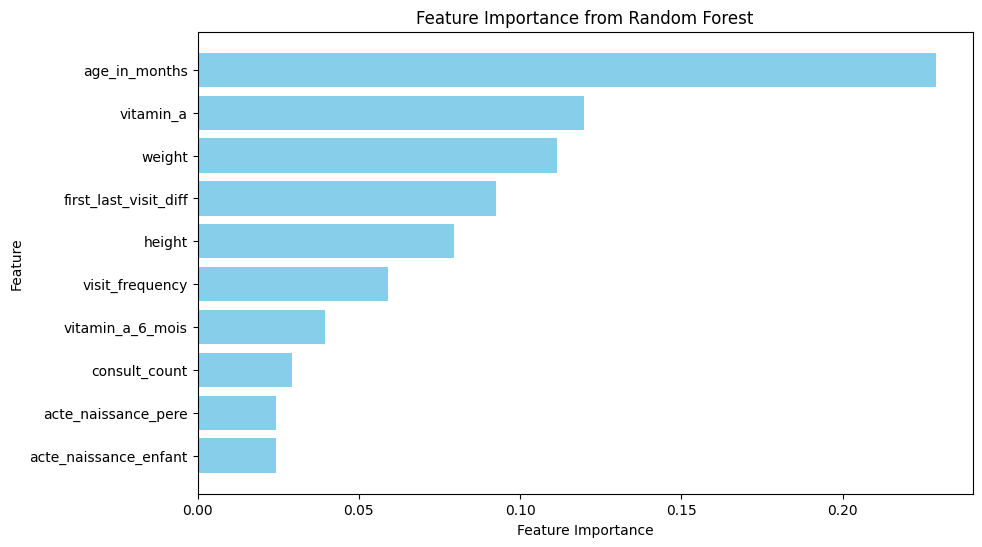

In [25]:
feature_importances = RF_classifier_merged_last_consult_best.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_df.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
display(importance_df)

top_features = importance_df.head(10)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.show()

## Random forest model using data from all consultations and the child table

In [41]:
sampled_consultations_table = pd.read_parquet('Data/sampled_consultation_table_for_training.parquet')

In [42]:
sampled_consultations_table.columns

Index(['age_in_months', 'has_diarrhea', 'has_dehydration', 'has_dysentery',
       'has_anemia', 'has_pneumonia', 'has_malaria', 'has_measles',
       'has_malnutrition', 'has_danger_signs',
       ...
       'region_id_region_0d8e', 'region_id_region_5ae5',
       'region_id_region_77e8', 'region_id_region_7dcc',
       'region_id_region_b52b', 'region_id_region_b57b',
       'region_id_region_b6cf', 'region_id_region_c3a2',
       'region_id_region_df42', 'region_id_region_fa25'],
      dtype='object', length=107)

In [43]:
# need to remove all the information about vaccines from the training data

vaccine_info_columns = ['all_vaccines', 'number_missed_vaccines', 'missed_vaccines_category']

X_df = sampled_consultations_table.drop(columns=vaccine_info_columns)

y_df = sampled_consultations_table['all_vaccines']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=2)

In [44]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier_merged_all_consultations = RandomForestClassifier(random_state=0)
RF_classifier_merged_all_consultations.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.79      0.83     73553
        True       0.93      0.96      0.95    229785

    accuracy                           0.92    303338
   macro avg       0.90      0.87      0.89    303338
weighted avg       0.92      0.92      0.92    303338

ROC-AUC: 0.96


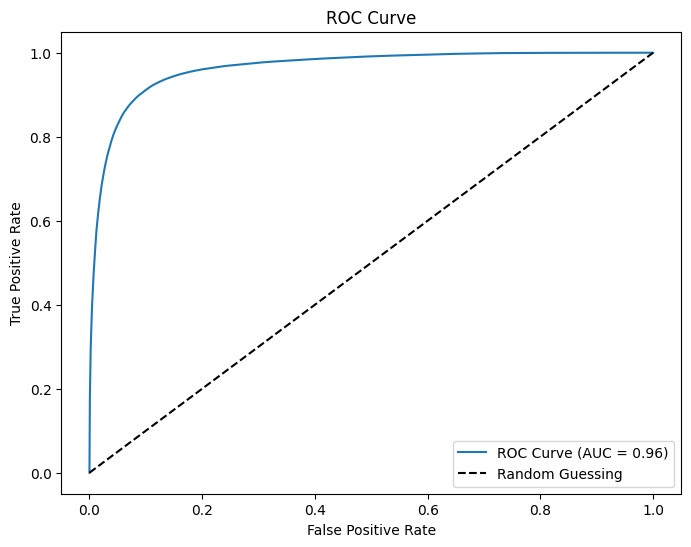

In [45]:
results_metrics(RF_classifier_merged_all_consultations, X_test=X_test, y_test=y_test)

We use GridSearchCV to choose the best parameters for RandomForestClassifier. As it is critical that we detect as many children as possible that might drop out, we prioritize recall for `'all_vaccines'==False` category.

In [46]:
sampled_consultations_table['all_vaccines'].value_counts(normalize=True)*100

all_vaccines
True     75.872989
False    24.127011
Name: proportion, dtype: float64

In [48]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV


# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2],
    'class_weight': [None, 'balanced', {0: 2, 1: 1}, {0: 3, 1: 1}],
    'max_features': ['log2','sqrt']
}

# Custom scorer for recall of the False class
custom_scorer = make_scorer(recall_score, pos_label=False)



grid_search_merged_all_consultations = GridSearchCV(
    RandomForestClassifier(random_state=2),
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search_merged_all_consultations.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_merged_all_consultations.best_params_)
print("Best Recall Score:", grid_search_merged_all_consultations.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  34.7s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  35.0s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  35.2s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  35.2s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n

/Users/dujell0000/Documents/H4G/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  54.5s
[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  53.5s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.9min
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.9min
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.9min
[CV] END class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  59.8s
[CV] END class_weight=None

/Users/dujell0000/Documents/H4G/.venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Recall Score: 0.8065915161101525


Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.81      0.73     73553
        True       0.94      0.87      0.90    229785

    accuracy                           0.86    303338
   macro avg       0.80      0.84      0.82    303338
weighted avg       0.87      0.86      0.86    303338

ROC-AUC: 0.92


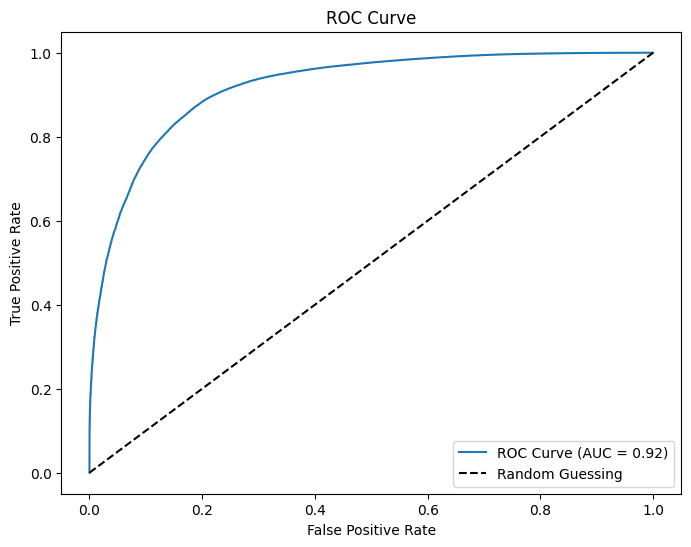

In [49]:
RF_classifier_merged_all_consultations = grid_search_merged_all_consultations.best_estimator_

# Print the best parameters
print("Best Parameters:", grid_search_merged_all_consultations.best_params_)

results_metrics(RF_classifier_merged_all_consultations, X_test=X_test, y_test=y_test)

Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.81      0.75     73553
        True       0.94      0.89      0.91    229785

    accuracy                           0.87    303338
   macro avg       0.82      0.85      0.83    303338
weighted avg       0.88      0.87      0.88    303338

ROC-AUC: 0.93


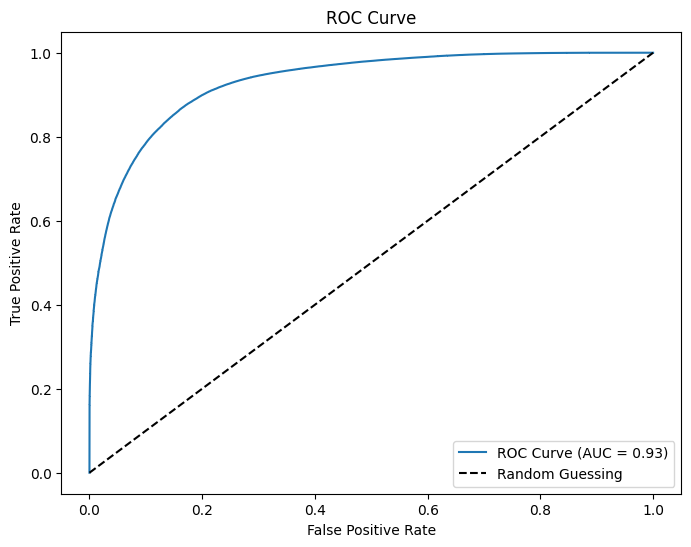

In [54]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier_merged_all_consultations = RandomForestClassifier(max_features='sqrt', class_weight={0: 3, 1: 1},n_estimators=200, min_samples_leaf=2, min_samples_split=10, max_depth=20, random_state=0)
RF_classifier_merged_all_consultations.fit(X_train, y_train)

results_metrics(RF_classifier_merged_all_consultations, X_test=X_test, y_test=y_test)

Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.82      0.81     73553
        True       0.94      0.94      0.94    229785

    accuracy                           0.91    303338
   macro avg       0.87      0.88      0.87    303338
weighted avg       0.91      0.91      0.91    303338

ROC-AUC: 0.95


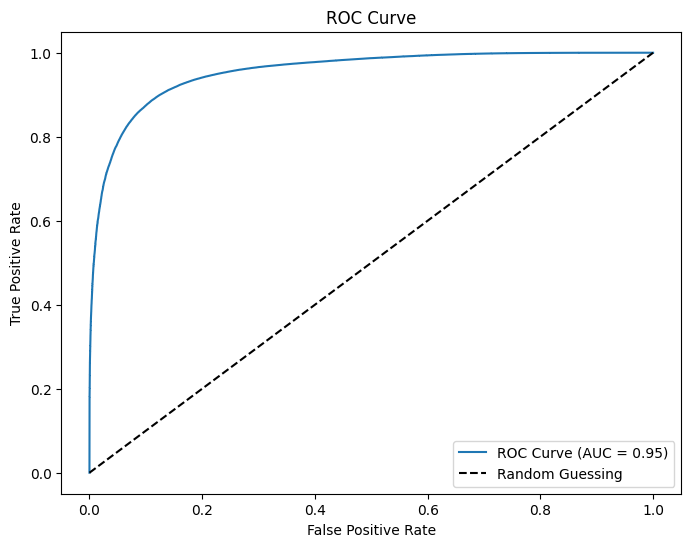

In [67]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier_merged_all_consultations = RandomForestClassifier(max_features='sqrt', class_weight={0: 3, 1: 1},n_estimators=100, min_samples_leaf=2, min_samples_split=5, max_depth=None, random_state=2)
RF_classifier_merged_all_consultations.fit(X_train, y_train)

results_metrics(RF_classifier_merged_all_consultations, X_test=X_test, y_test=y_test)


Feature Importance:


,Feature,Importance
29,first_last_visit_diff,1.267869e-01
0,age_in_months,1.258960e-01
31,visit_frequency,1.087896e-01
23,weight,8.648545e-02
26,vitamin_a,7.824490e-02
...,...,...
7,has_measles,1.647027e-05
13,has_suspicion_tuberculosis,4.733866e-06
1,has_diarrhea,3.990276e-06
12,has_suspicion_asthma,3.152552e-08


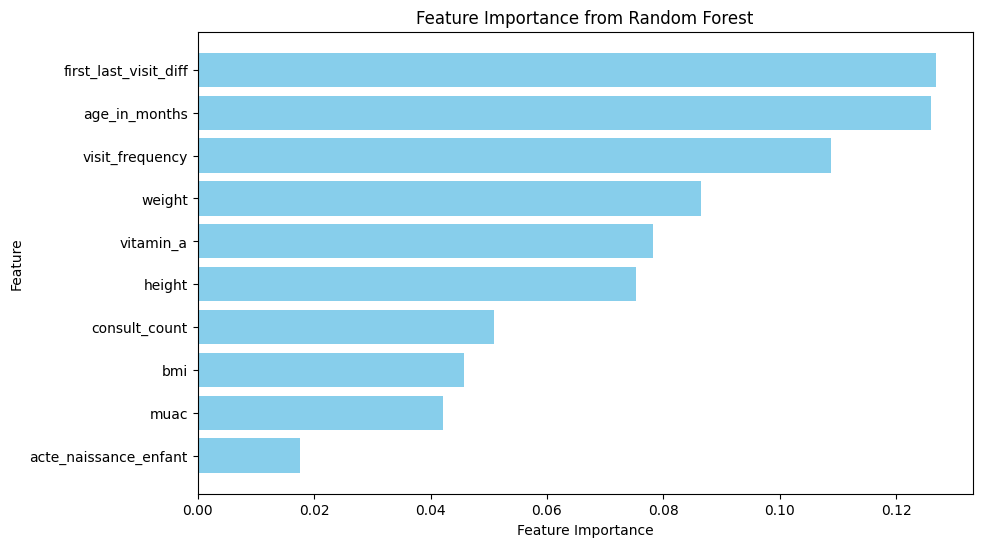

In [70]:
feature_importances = RF_classifier_merged_all_consultations.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_df.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
display(importance_df)

top_features = importance_df.head(10)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.show()